In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
import pqr


# Load and preprocess the data

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', parse_dates=True, index_col=0)
pe = pd.read_excel('factors/russia/PE.xlsx', parse_dates=True, index_col=0)
volume = pd.read_excel('factors/russia/betafilter.xlsx', parse_dates=True, index_col=0)

for df in (prices, pe, volume):
    df.replace(0, np.nan, inplace=True)

# Define stock universe, prepare factors and benchmark

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Median(3),
    pqr.Hold(3),
)

value = factorizer(pe, better="less")

benchmark = pqr.Benchmark.from_universe(universe)

# Setup portfolio formation

In [5]:
builder = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    pqr.TheoreticalAllocation(),
)

# Build a factor model

In [6]:
fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 1/3),
        pqr.fm.Quantiles(1/3, 2/3),
        pqr.fm.Quantiles(2/3, 1)
    ],
    portfolio_builder=builder,
    add_wml=True
)

portfolios = fm(value, universe)

# Analyse the results

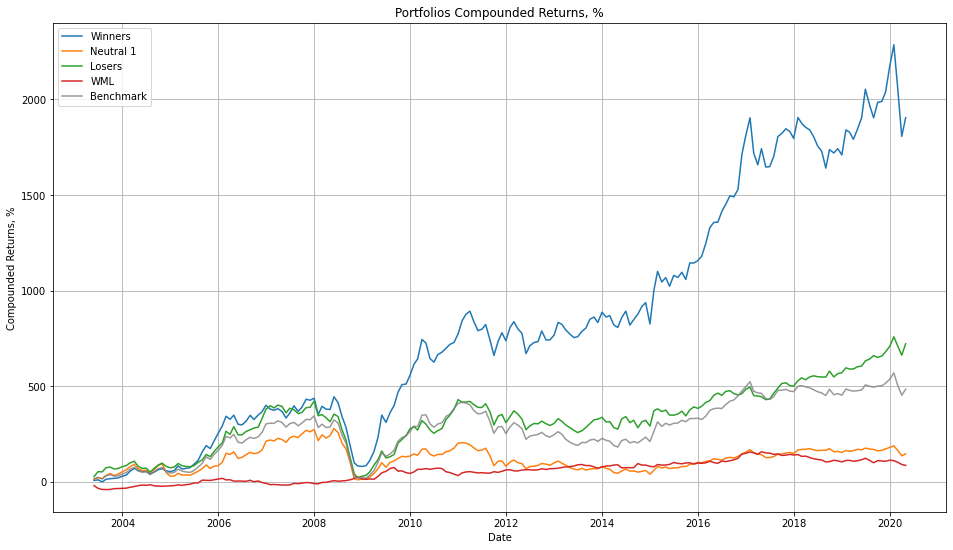

,Winners,Neutral 1,Losers,WML
"Total Return, %",1903.52,145.89,721.37,85.68
"CAGR, %",19.28,5.43,13.19,3.71
"Mean Return, %",21.36*** (3.27),9.42* (1.40),16.41*** (2.43),4.95 (1.27)
"Volatility, %",26.95,27.70,27.80,16.10
"Win Rate, %",61.76,59.31,61.27,56.37
"Mean Turnover, %",197.93,286.04,220.85,418.78
"Maximum Drawdown, %",-66.87,-70.80,-76.90,-29.74
"Value at Risk, %",-33.52,-44.06,-41.13,-23.75
"Expected Tail Loss, %",-51.64,-67.04,-60.64,-35.95
"Expected Tail Reward, %",67.18,54.58,67.36,37.65


In [7]:
summary = pqr.dash.SummaryDashboard(benchmark)
summary(portfolios)

# Tests

In [8]:
zi = pqr.tests.ZeroIntelligenceTest(
    universe,
    builder,
    pqr.metrics.TrailingMeanReturn(),
)

prophet = pqr.tests.ProphetTest(
    universe,
    builder,
    pqr.metrics.TrailingMeanReturn()
)

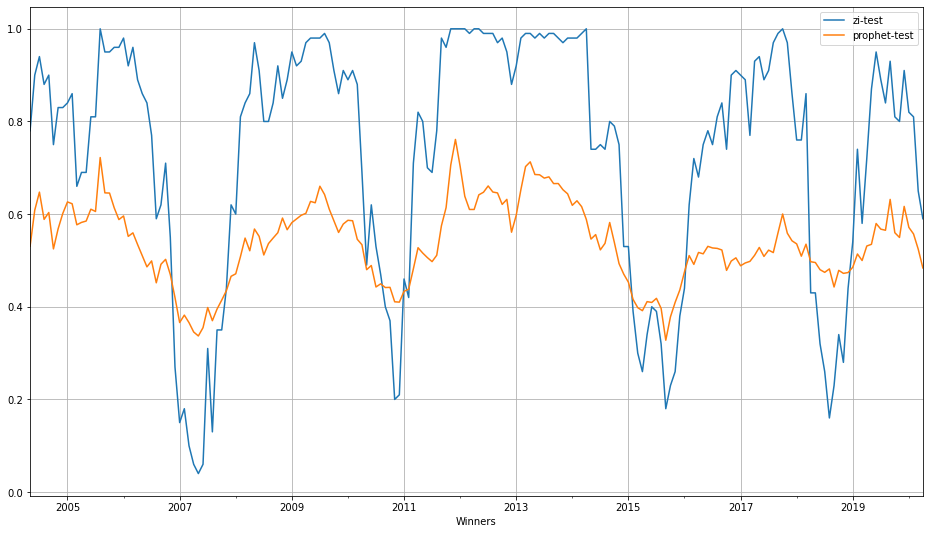

In [9]:
res_zi = zi(portfolios[0])
res_prophet = prophet(portfolios[0])


res_zi.plot(label="zi-test")
res_prophet.plot(label="prophet-test")

plt.legend()
plt.grid()